In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [128]:
import math
import os
import shutil
from collections import Counter
from pathlib import Path

import nfp
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from nfp.layers import RBFExpansion
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tqdm.auto import tqdm

In [95]:
inputs_dir = Path("/projects/rlmolecule/pstjohn/crystal_inputs/")

In [106]:
data = pd.read_pickle(Path(inputs_dir, "20211227_all_data.p"))
preprocessor = PymatgenPreprocessor()
preprocessor.from_json(Path(inputs_dir, "20211227_preprocessor.json"))

train, valid = train_test_split(data, test_size=2000, random_state=1)
valid, test = train_test_split(valid, test_size=0.5)

def calculate_output_bias(train):
    """ We can get a reasonable guess for the output bias by just assuming the crystal's
     energy is a linear sum over it's element types """
    # This just converts to a count of each element by crystal
    site_counts = train.inputs.progress_apply(
        lambda x: pd.Series(Counter(x["site"]))
    ).fillna(0)
    # Linear regression assumes a sum, while we average over sites in the neural network.
    # Here, we make the regression target the total energy, not the site-averaged energy
    num_sites = site_counts.sum(1)
    total_energies = train["energyperatom"] * num_sites

    # Do the least-squares regression, and stack on zeros for the mask and unknown tokens
    output_bias = np.linalg.lstsq(site_counts, total_energies, rcond=None)[0]
    output_bias = np.hstack([np.zeros(2), output_bias])
    return output_bias


# Calculate an initial guess for the output bias
output_bias = calculate_output_bias(train)

  0%|          | 0/68909 [00:00<?, ?it/s]

In [159]:
all_dists = np.concatenate(data.inputs.apply(lambda x: x['distance']).values)

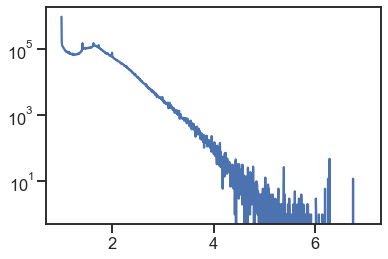

In [179]:
y, x = np.histogram(all_dists, range=(1, 7), bins=1000)
plt.plot(x[1:], y)
plt.yscale('log')

In [59]:
def build_dataset(split):
    return (
        tf.data.Dataset.from_generator(
            lambda: ((row.inputs, row.energyperatom) for _, row in split.iterrows()),
            output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))
        .cache()
        .shuffle(buffer_size=len(split))    
        .padded_batch(batch_size=128, padding_values=(preprocessor.padding_values, tf.constant(np.nan, dtype=tf.float32)))
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
train, valid = train_test_split(data, test_size=1000, stratify=data.comp_type)
valid, test = train_test_split(valid, test_size=0.5)

In [62]:
train_dataset = build_dataset(train)

In [75]:
np.concatenate(site_types)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 48 and the array at index 7 has size 40

In [82]:
from collections import Counter

In [86]:
train.head(100).inputs.apply(lambda x: pd.Series(Counter(x['site']))).fillna(0)

,2,3,4,5,6,7,8,9,10,11,...,20,21,22,23,24,25,26,27,28,29
37016,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0
12951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
43576,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,10.0,0.0
51492,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31731,6.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9893,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
38346,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39537,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
from tqdm.auto import tqdm
tqdm.pandas()

In [124]:
# This just converts to a count of each element by crystal
site_counts = train.inputs.progress_apply(lambda x: pd.Series(Counter(x['site']))).fillna(0)
# Linear regression assumes a sum, while we average over sites in the neural network.
# Here, we make the regression target the total energy, not the site-averaged energy
num_sites = site_counts.sum(1)
total_energies = train['energyperatom'] * num_sites

# Do the least-squares regression, and stack on zeros for the mask and unknown tokens
output_bias = np.linalg.lstsq(site_counts, total_energies, rcond=None)[0]
output_bias = np.hstack([np.zeros(2), output_bias])

  0%|          | 0/68909 [00:00<?, ?it/s]

In [125]:
pred_linear = (site_counts @ np.linalg.lstsq(site_counts, total_energies, rcond=None)[0]) / num_sites

In [118]:
from sklearn.metrics import mean_absolute_error

In [126]:
mean_absolute_error(pred_linear, train['energyperatom'])

0.2774262841351785

In [109]:
np.sqrt(3225120) / len(train)

0.026061354976255474

In [93]:
output_bias

array([  0.        ,   0.        ,  -0.35386067,  -5.04603822,
        -5.82722222,  -3.4960666 ,  -1.92183528,  -7.95527783,
         0.78714291,  -7.87406679,  -2.86423775, -11.05412017,
        -0.96718567,  -3.25319527,  -2.09999966,  -9.34459072,
        -3.00677933,  -8.39919494,  -1.58762715,  -8.79313123,
        -5.76760915,  -2.83021062,  -4.98811183,  -7.88154747,
        -5.00972514,  -3.42817016,  -7.48886232,  -6.60338796,
        -2.8215705 ,  -8.87809633])

In [152]:
# Keras model
site_class = layers.Input(shape=[None], dtype=tf.int64, name="site")
distances = layers.Input(shape=[None], dtype=tf.float32, name="distance")
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name="connectivity")
input_tensors = [site_class, distances, connectivity]

embed_dimension = 256
num_messages = 6

atom_state = layers.Embedding(
    preprocessor.site_classes, embed_dimension, name="site_embedding", mask_zero=True
)(site_class)

atom_mean = layers.Embedding(
    preprocessor.site_classes,
    1,
    name="site_mean",
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.Constant(output_bias),
)(site_class)

rbf_distance = RBFExpansion(
    dimension=128, init_max_distance=7, init_gap=30, trainable=True
)(distances)

bond_state = layers.Dense(embed_dimension)(rbf_distance)

for _ in range(num_messages):
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
    bond_state = layers.Add()([bond_state, new_bond_state])
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
    atom_state = layers.Add()([atom_state, new_atom_state])

# Reduce the atom state vector to a single energy prediction
atom_state = layers.Dense(
    1,
    name="site_energy_offset",
    kernel_initializer=tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=1e-6, seed=None
    ),
)(atom_state)

# Add this 'offset' prediction to the learned mean energy for the given element type
atom_state = layers.Add(name="add_energy_offset")([atom_state, atom_mean])

# Calculate a final mean energy per atom
out = tf.keras.layers.GlobalAveragePooling1D()(atom_state)

model = tf.keras.Model(input_tensors, [out])

In [150]:
train_dataset = (
        tf.data.Dataset.from_generator(
            lambda: ((row.inputs, row.energyperatom) for _, row in train.iterrows()),
            output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))
        .cache()
        .padded_batch(batch_size=128, padding_values=(preprocessor.padding_values, tf.constant(np.nan, dtype=tf.float32)))
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

In [151]:
model.compile(loss="mae", optimizer='adam')
model.evaluate(train_dataset, verbose=1)

     19/Unknown - 5s 164ms/step - loss: 0.3614

KeyboardInterrupt: 

In [ ]:
train['energyperatom']